# Signal synthesis

In this notebook we evaluate the data from the direct digital synthesis measurements in order to characterize the signal source quality.

In [1]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

datadir = '../../dataset/signal/synthesis'
figuredir = '../../figure/signal/synthesis'

os.makedirs(figuredir, exist_ok=True)

In [2]:
t = np.linspace(0, 6e-7, 3000)

t1 = t[:1000]
t2 = t[1000:2000]
t3 = t[2000:]

f1 = 80e6
f2 = 100e6
f3 = 120e6

U1 = np.cos(2*np.pi*f1*t1)
U2 = np.cos(2*np.pi*f2*t2)
U3 = np.cos(2*np.pi*f3*t3)

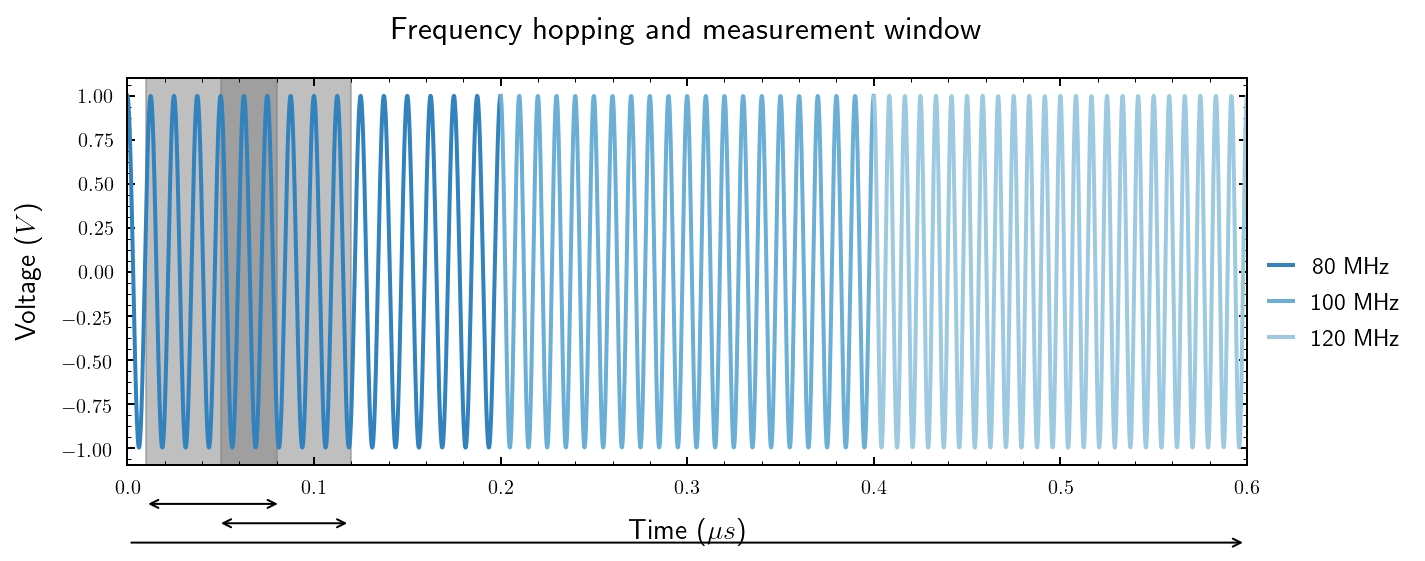

In [3]:
cmap = plt.get_cmap('tab20c')

plt.figure(figsize=(10, 4))
plt.title('Frequency hopping and measurement window')
plt.plot(t1 / 1e-6, U1, label='80 MHz', color=cmap.colors[0])
plt.plot(t2 / 1e-6, U2, label='100 MHz', color=cmap.colors[1])
plt.plot(t3 / 1e-6, U3, label='120 MHz', color=cmap.colors[2])
plt.axvspan(1e-2, 8e-2, color='gray', alpha=0.5)
plt.axvspan(5e-2, 12e-2, color='gray', alpha=0.5)
plt.xlabel('Time ($\mu s$)')
plt.ylabel('Voltage ($V$)')
plt.legend(loc='right center', bbox_to_anchor=(1.0, .6))
plt.margins(x=0)
plt.tight_layout()
plt.annotate('', xy=(0.015, -0.1), xycoords='axes fraction', xytext=(.138, -0.1), 
            arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate('', xy=(0.08, -0.15), xycoords='axes fraction', xytext=(.2, -0.15), 
            arrowprops=dict(arrowstyle="<->", color='black'))
plt.annotate('', xy=(0.0, -0.2), xycoords='axes fraction', xytext=(1, -0.2), 
            arrowprops=dict(arrowstyle="<-", color='black'))
plt.savefig(os.path.join(figuredir, 'sweep-window.pdf'))
plt.show()

We are interested in the signal amplitude in dependence of the frequency. Thus we will do a FFT on each segment to identify the dominant frequency and take the maximum voltage as amplitude. Then we compare the different configuration.

In [4]:
duration = 30e-3
delays = np.linspace(0, duration, 300)

In [67]:
runs = {
    'horizontal': {},
    'vertical': {}
}

for key in runs.keys():
    runs[key] = {d: pd.read_hdf(os.path.join(datadir, f'{key}.h5'), f'{d:.4}') for d in delays}

In [68]:
import transform

f_h = []
f_v = []
A_h = []
A_v = []

for t, df in runs['horizontal'].items():
    f, P = transform.fft(df.time, df.voltage)
        
    f_h.append(f[P.argmax()])
    A_h.append(df.voltage.max())
    
for t, df in runs['vertical'].items():
    f, P = transform.fft(df.time, df.voltage)
        
    f_v.append(f[P.argmax()])
    A_v.append(df.voltage.max())
    
f_h = np.array(f_h)
A_h = np.array(A_h)
f_v = np.array(f_v)
A_v = np.array(A_v)

In [70]:
samp_h = pd.read_hdf(os.path.join(datadir, 'sampled.h5'), 'horizontal')
samp_v = pd.read_hdf(os.path.join(datadir, 'sampled.h5'), 'vertical')

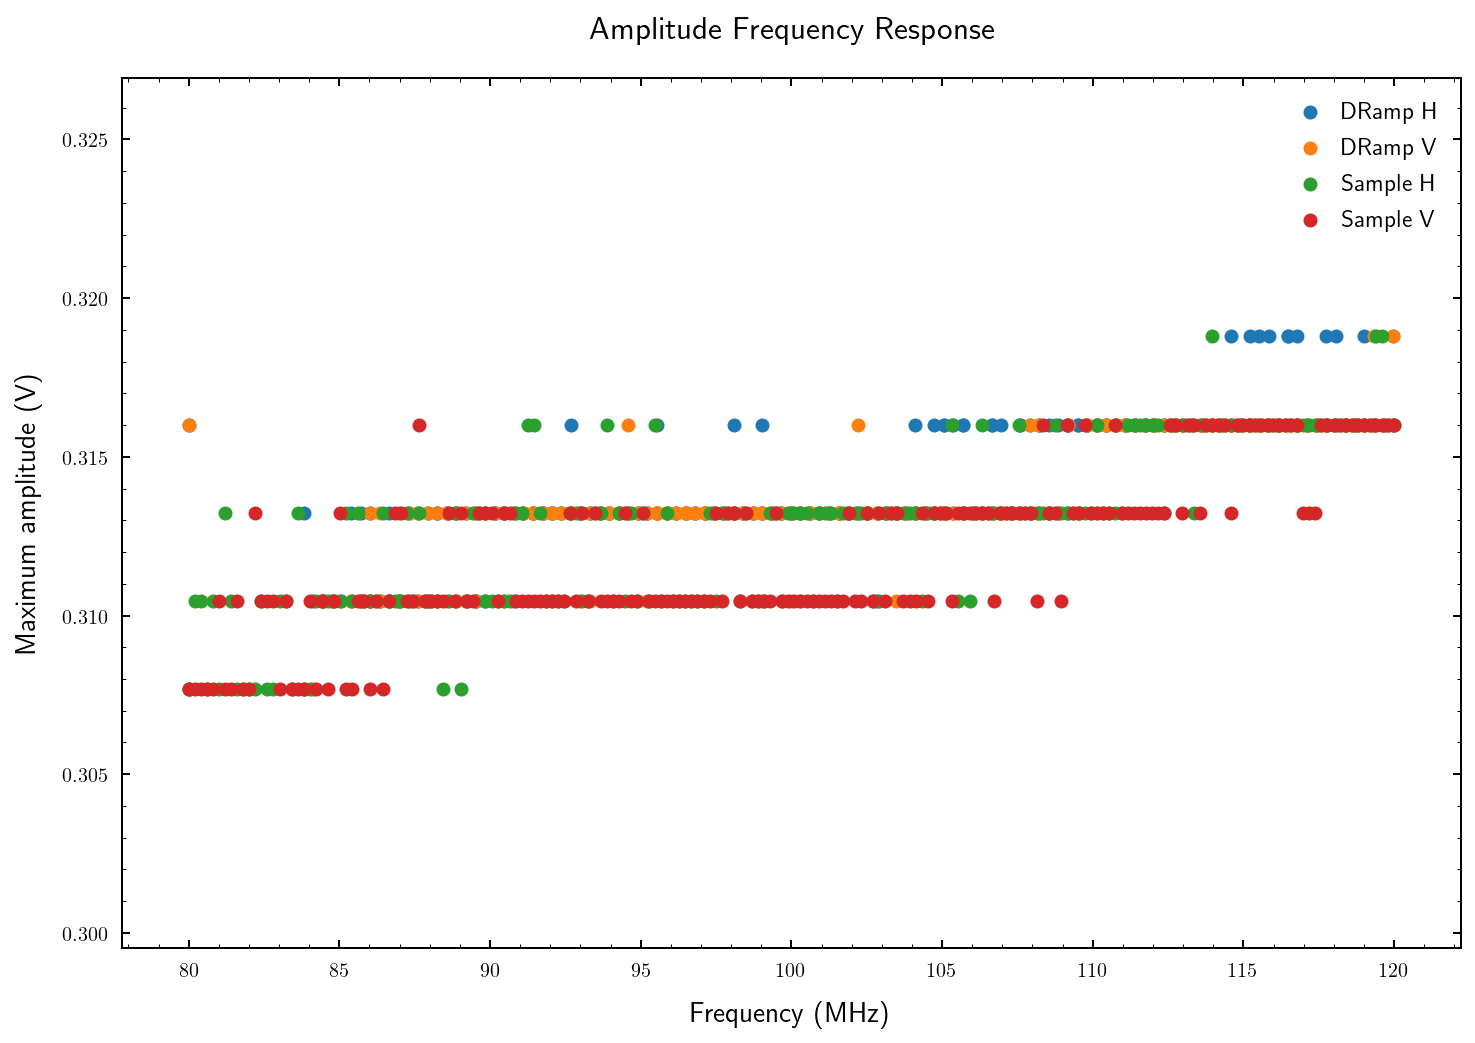

In [72]:
fig = plt.figure(figsize=(12, 8))

plt.scatter(f_h[f_h > 0] / 1e6, A_h[f_h > 0], label='DRamp H')
plt.scatter(f_v[f_v > 0] / 1e6, A_v[f_v > 0], label='DRamp V')

plt.scatter(samp_h.frequency / 1e6, samp_h.amplitude, label='Sample H')
plt.scatter(samp_v.frequency / 1e6, samp_v.amplitude, label='Sample V')

plt.title('Amplitude Frequency Response')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Maximum amplitude (V)')
plt.legend()
fig.savefig(os.path.join(figuredir, 'frequency-response.pdf'))
plt.show()

In [50]:
from matplotlib import mlab

tmin = runs[delays[0]].time.min()
tmax = runs[delays[0]].time.max()

t0 = delays[10]
t1 = delays[99]
t2 = delays[199]
t3 = delays[299-3]

df = runs
dt = df[t0].time.diff()[1]

NFFT = 1024
Fs = 1/dt

Pxx1, freq1, bin1 = mlab.specgram(df[t0].voltage, NFFT=NFFT, Fs=Fs, noverlap=900)
Pxx2, freq2, bin2 = mlab.specgram(df[t1].voltage, NFFT=NFFT, Fs=Fs, noverlap=900)
Pxx3, freq3, bin3 = mlab.specgram(df[t2].voltage, NFFT=NFFT, Fs=Fs, noverlap=900)
Pxx4, freq4, bin4 = mlab.specgram(df[t3].voltage, NFFT=NFFT, Fs=Fs, noverlap=900)

minfreq = 60e6
maxfreq = 140e6

Pxx1 = Pxx1[(freq1 >= minfreq) & (freq1 <= maxfreq)]
Pxx2 = Pxx2[(freq2 >= minfreq) & (freq2 <= maxfreq)]
Pxx3 = Pxx3[(freq3 >= minfreq) & (freq3 <= maxfreq)]
Pxx4 = Pxx4[(freq4 >= minfreq) & (freq4 <= maxfreq)]

freq1 = freq1[(freq1 >= minfreq) & (freq1 <= maxfreq)]
freq2 = freq2[(freq2 >= minfreq) & (freq2 <= maxfreq)]
freq3 = freq3[(freq3 >= minfreq) & (freq3 <= maxfreq)]
freq4 = freq4[(freq4 >= minfreq) & (freq4 <= maxfreq)]

vmin = np.array([Pxx1.min(), Pxx2.min(), Pxx3.min(), Pxx4.min()]).min()
vmax = np.array([Pxx1.max(), Pxx2.max(), Pxx3.max(), Pxx4.max()]).max()

Z1 = np.flipud(Pxx1)
Z2 = np.flipud(Pxx2)
Z3 = np.flipud(Pxx3)
Z4 = np.flipud(Pxx4)

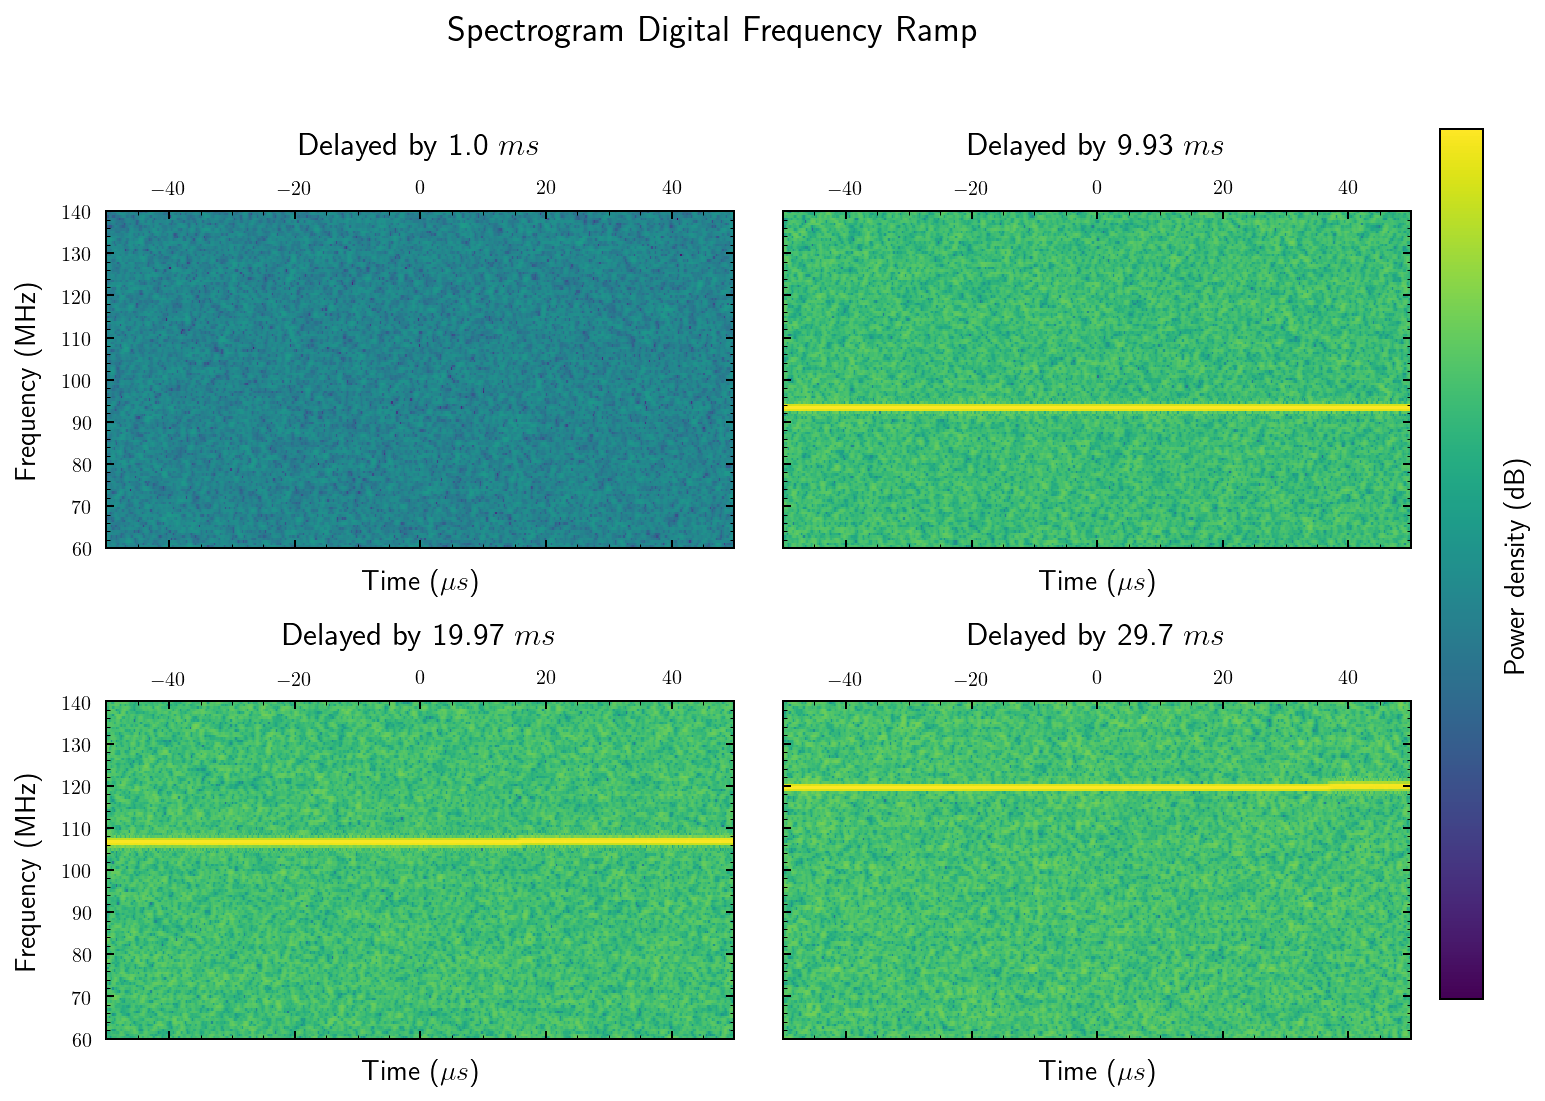

In [66]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatter 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharey=True)
fig.suptitle('Spectrogram Digital Frequency Ramp')

axes = axes.flatten()
axes[0].set_title(f'Delayed by {(t0 / 1e-3):.3} $ms$')
axes[0].set_ylabel('Frequency (MHz)')
axes[0].matshow(Z1, extent=[tmin / 1e-6, tmax / 1e-6, 60, 140], norm=LogNorm(vmin=vmin, vmax=vmax))
axes[1].set_title(f'Delayed by {(t1 / 1e-3):.3} $ms$')
axes[1].matshow(Z2, extent=[tmin / 1e-6, tmax / 1e-6, 60, 140], norm=LogNorm(vmin=vmin, vmax=vmax))
axes[2].set_title(f'Delayed by {(t2 / 1e-3):.4} $ms$')
axes[2].matshow(Z3, extent=[tmin / 1e-6, tmax / 1e-6, 60, 140], norm=LogNorm(vmin=vmin, vmax=vmax))
axes[2].set_ylabel('Frequency (MHz)')
axes[3].set_title(f'Delayed by {(t3 / 1e-3):.4} $ms$')
im = axes[3].matshow(Z4, extent=[tmin / 1e-6, tmax / 1e-6, 60, 140], norm=LogNorm(vmin=vmin, vmax=vmax))

for axis in axes:
    axis.set_xlabel('Time ($\mu s$)')
    axis.axis('auto')

formatter = LogFormatter(10, labelOnlyBase=False) 
#cb = plt.colorbar(ticks=[1,5,10,20,50], format=formatter)
    
fig.subplots_adjust(right=1.16)
fig.colorbar(im, ax=list(axes), label='Power density (dB)', format=formatter,ticks=[1,5,10,20,50],)

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
#fig.savefig(os.path.join(figuredir, 'spectrogram.pdf'))
plt.show()

## Conclusion

We find that the amplitude of the DDS has a frequency dependence. The datasheet suggests that this is an intrinsic property of direct digital synthesis and advertises an inverse sinc filter to circumvent the frequency dependence.

We find that the inverse sinc filter does not really eliminate the frequency dependence of the amplitude but decreases the overall power output, henceforth we decide to not use the inverse sinc filter in any further experiments.